# BabelNet biding Python <-> Java

This notebook shows how we can extract information from BabelNet to improve our knowledge graph.
BabelNet is heavily inspired on WordNet, and structured alike so that multiple lexemes may correspond to the same synset.

First, we are going to build and import a bridge between BabelNet and Python. This is required due to a limitation in PyJnius method overloading management.

In [26]:
!cd tools/BabelNet && sbt -warn package 2>&1 > /dev/null || echo "Installation did not work, rerun this command without redirections to see why"

In [ ]:
import os
import jnius_config

prefix =  "/nfs/knowledge-glue/notebooks/3rdparty/lucene-index"
scala_path = "/usr/share/scala-2.11/lib/scala-library.jar"
# BabelNet bridge
local_tools = os.path.join(os.getcwd(), "tools/BabelNet/target/scala-2.11/babelnetbridge_2.11-0.1.jar")
jnius_config.set_classpath(prefix + "/babelnet-api-4.0.1.jar", prefix + "/lib/*", local_tools, scala_path )
print(jnius_config.get_classpath())
import jnius

In [2]:
# Jeff, forgive me for I hath sinned
def jimport(path):
    """
    Wrap a jnius import. This adds a global variable
    This adds a global variable with the name of the class.
    
    >>> jimport("java.lang.Math")
    >>> Math.sqrt(100)
    10.0
    
    As pyjnius does not seem to import static fields or subclasses
    automatically via an 'autoclass' invocation, one needs to
    import it manually:
    
    >>> jimport("org.mypackage.myclass")
    >>> jimport("org.mypackage.myclass$nestedclass")
    
    At the moment it is not allowed to import a nested class alone.
    """
    
    classname = path.split(".")[-1]
    if "$" in classname:
        parent_class, subclass = classname.split("$")
        exec("""
global ?parent_class
?parent_class.?subclass = jnius.autoclass(path)
""".replace("?parent_class", parent_class).replace("?subclass", subclass),
             globals(), {'path': path})
    else:
        exec("""
global ?classname
?classname = jnius.autoclass(path)
    """.replace("?classname", classname), globals(), {'path': path})

In [3]:
jimport("it.uniroma1.lcl.babelnet.BabelNet")
jimport("it.uniroma1.lcl.babelnet.BabelNetQuery")
jimport("it.uniroma1.lcl.babelnet.BabelNetQuery$Builder")
jimport("it.uniroma1.lcl.babelnet.BabelSynset")
jimport("it.uniroma1.lcl.jlt.util.Language")
jimport("com.babelscape.util.UniversalPOS")
jimport("tools.BabelNetBridge")
jimport("tools.BabelNetLexeme")

In [4]:
import os

from pyspark import SparkContext
from pyspark.sql import SparkSession

parquet_pos = os.path.join(os.getcwd(), "data/wiktionary/parquet-index_2.11-0.4.1-SNAPSHOT.jar")

spark = SparkSession.builder \
                        .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
                        .config("spark.jars", parquet_pos) \
                        .getOrCreate()

spark.sparkContext.addPyFile(parquet_pos)

In [5]:
wiktionary_2_wdpg = spark.read.parquet("spark-warehouse/wiktionary_2_wdpg")

In [6]:
from tools.rdf_dumping import ExtractorGraph

In [112]:
graph = ExtractorGraph()

for row in wiktionary_2_wdpg.rdd.toLocalIterator():
    if(row['head']['template_name'] != 'head'):
        graph.add_wiktionary(row)

In [113]:
from rdflib import Namespace
# TODO: check that the IRI is actually this one
babelnet_iri = "http://babelnet.org/rdf/page/"
bn = Namespace(babelnet_iri)

In [114]:
graph.g.bind('bn', bn)

In [17]:
from tools.rdf_dumping import rdf_type, kgl, kgl_prop
from tools.strings import strip_prefix
import re
# Match a sense, in the form of kgl:entity-Sx
matcher = re.compile("^(.*)-S\d+")
# for simplicity, a sense only has one gloss
sense_names = []
sense_glosses = []

for (sense, _, sense_description) in graph.g.triples((None, kgl_prop['definition'], None)):
    if not matcher.match(sense):
        continue
    if sense_description.language == "en":
        sense_names.append(sense.toPython())
        sense_glosses.append(sense_description.toPython())

In [11]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [12]:
# This is potentially slow, beware!
import numpy as np

sense_embeddings_path = "data/wiktionary/senses_encoded.npy"
if os.path.exists(sense_embeddings_path):
    sense_embeddings = np.load(sense_embeddings_path)
else:
    sense_embeddings = model.encode(sense_glosses)
    np.save(sense_embeddings_path, sense_embeddings)

In [13]:
sense_gloss_dict = dict(zip(sense_names, zip(sense_glosses, sense_embeddings)))

In [28]:
for result in BabelNetBridge.getSynsetsForLexeme("home", "noun"):
    print(result.id().getID())

bn:00044489n
bn:00044994n
bn:01247597n
bn:01743978n
bn:00660545n
bn:00044492n
bn:02516029n
bn:03270052n
bn:03115045n
bn:03102167n
bn:03891547n
bn:00140446n
bn:03489135n
bn:01095781n
bn:03764814n
bn:00000301n
bn:00006679n
bn:02442871n
bn:02738391n
bn:03482773n
bn:00008792n
bn:02126016n
bn:00044490n
bn:00196994n
bn:03183031n
bn:03298576n
bn:03587884n
bn:00401397n
bn:03280967n
bn:00044488n
bn:01237214n
bn:00044491n
bn:01975454n
bn:03614951n
bn:00044514n
bn:02269544n
bn:01678148n
bn:03740189n
bn:00032892n
bn:00000356n
bn:00118263n
bn:00600151n
bn:00044503n
bn:01669387n
bn:14906373n
bn:02938766n
bn:02092291n
bn:02449284n
bn:03089315n
bn:03879597n
bn:03838736n
bn:00605019n
bn:03603430n
bn:00502400n
bn:03184515n
bn:01579709n
bn:01062453n
bn:00861103n
bn:01359805n


## Small distribution

In [32]:
wordlist = wiktionary_2_wdpg.select(["word", "pos"]).collect()

In [89]:
excluded_pos = {"prep", "postp", "abbrev", "phrase", "article", "name", "conj", "symbol", "particle"}

In [45]:
wiktionary_2_wdpg.select("pos").distinct().collect()

[Row(pos='abbrev'),
 Row(pos='conj'),
 Row(pos='det'),
 Row(pos='name'),
 Row(pos='prep'),
 Row(pos='postp'),
 Row(pos='pron'),
 Row(pos='particle'),
 Row(pos='symbol'),
 Row(pos='num'),
 Row(pos='phrase'),
 Row(pos='adj'),
 Row(pos='article'),
 Row(pos='adv'),
 Row(pos='verb'),
 Row(pos='intj'),
 Row(pos='noun')]

In [ ]:
from collections import defaultdict

freq_counter = defaultdict(int)
counted = set()

for entry in wordlist:
    word = entry.word
    pos = entry.pos
    
    if pos in excluded_pos:
        continue
        
    if (word, pos) in counted:
        continue
        
    counted.add((word, pos))
    
    try:
        #print(f"Adding {word}-{pos}")
        for synset in BabelNetBridge.getSynsetsForLexeme(word, pos):
            for edge in synset.relatedWords():
                freq_counter[edge.getPointer().toString()]+=1
    finally:
        pass
print(freq_counter)

<BarContainer object of 25 artists>

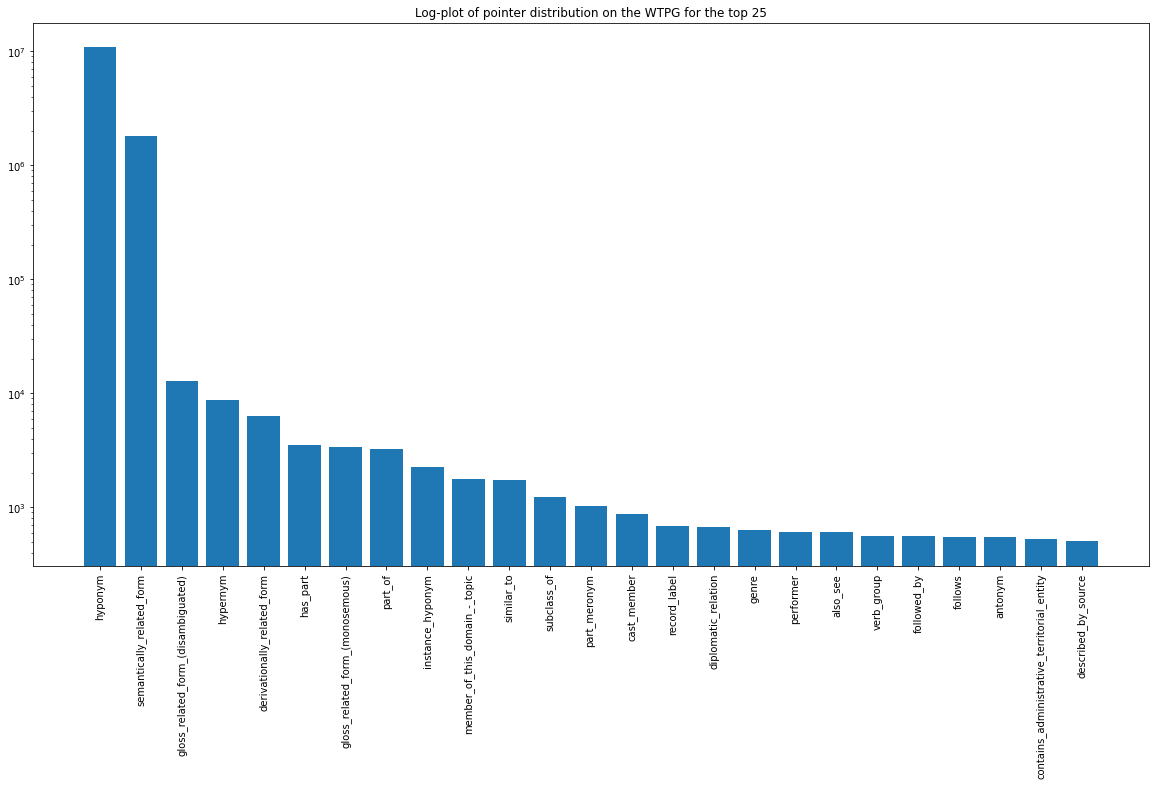

In [88]:
import matplotlib.pyplot as plt


threshold = 25
filtered = sorted(freq_counter.items(), key=lambda x: x[1])[-threshold:][::-1]

keys = [x[0] for x in filtered]
values = [x[1] for x in filtered]

fig = plt.figure(figsize=(20, 10))
plt.xticks(range(len(keys)), keys, rotation='vertical')

plt.title(f"Log-plot of pointer distribution on the WTPG for the top {threshold}")
plt.bar(keys, values, log=True)

In [98]:
jimport("it.uniroma1.lcl.babelnet.data.BabelPointer")

In [ ]:
from tools.rdf_dumping import rdf_type, kgl, kgl_prop
from tools.strings import strip_prefix
#import re
#matcher = re.compile("^(.*)-S\d+")
related_to = {}
form_matcher = re.compile("^(.*)-F\d+")

def handle_pointer(lexeme, synset, edges):
    BP = BabelPointer
    pointer_filter = [BP.HYPONYM, BP.HYPERNYM, BP.ALSO_SEE, 
                         BP.SEMANTICALLY_RELATED, BP.DERIVATIONALLY_RELATED,
                         BP.GLOSS_MONOSEMOUS, BP.SIMILAR_TO,
                         BP.ANTONYM, BP.VERB_GROUP]
    
    syntactic_pointers = [BP.DERIVATIONALLY_RELATED]
    
    edges = [p for p in edges if p.getPointer() in pointer_filter]
    
    for edge in edges:
        pointer = edge.getPointer()
        endpoint = edge.getBabelSynsetIDTarget()
        endpoint_prefixed = bn[endpoint.getID()[2:]]
        synset_id = bn[synset.id.getID()[2:]]
    
        # If the pointer is a semantic pointer, then one should only
        # keep the links between synsets
        if pointer not in syntactic_pointers:
            print(synset_id)
            print(endpoint_prefixed)
            #graph.g.add(synset_id, kgl_prop[pointer.getShortName()], endpoint_prefixed)
            
        else:            
            endpoint_synset = BabelSynset(endpoint)
            endpoint_lemma = endpoint_synset.getMainSense().get().getFullLemma()
            endpoint_pos = endpoint_synset.getPOS()
            destination_entity = kgl[graph.hash(endpoint_lemma, endpoint_pos.toString().lower())]
            #graph.g.add(lexeme, kgl_prop[pointer.getShortName()], destination_entity )
        

seen = set()

def query_babelnet(lexeme, word: str, pos: str):
    pos = strip_prefix("http://grill-lab.org/kg/entity/", pos)
    if pos in excluded_pos:
        return
    
    if (word, pos) in seen:
        return
    
    #seen.add((word, pos))
    
    synsets = BabelNetBridge.getSynsetsForLexeme(word, pos)
    if len(synsets) == 0:
        return
    
    senses = [triple[2] for triple in graph.g.triples((lexeme, kgl_prop['sense'], None))]
    
    print(f"For word {word} ({pos})")

    pertaining_senses = [sense_gloss_dict[sense.toPython()] for sense in senses]
    print([gloss for gloss, embed in pertaining_senses])
    wiktionary_senses_embed = np.array([embed for gloss, embed in pertaining_senses])
    
    for synset in synsets:
        
        babelnet_id = synset.id().getID()
        res_synsets = synset.synsets()
        if len(res_synsets):
            glosses = res_synsets[0].getGloss()
        related = synset.relatedWords()
        
        # sources = [source.toString() for source in BabelNet.getInstance().getSynset(synset.id()).getSenseSources()]
        # print(sources)

        print(f"Determining embeddings for {babelnet_id} ({word})")
        glosses_embedded = np.array(model.encode([glosses]))
        glosses_embedded /= np.linalg.norm(glosses_embedded)
        
        # print(wiktionary_senses_embed.shape)
        # print(np.linalg.norm(wiktionary_senses_embed, axis=1).shape)
        wiktionary_senses_embed /= np.linalg.norm(wiktionary_senses_embed, axis=1)[:, np.newaxis]
        
        #print(glosses_embedded.shape)
        #print(wiktionary_senses_embed.T.shape)
        cosine_similarity = glosses_embedded.flatten() @ wiktionary_senses_embed.T
        
        # print(cosine_similarity)
        
        best_match = np.argmax(cosine_similarity)
        print(f"Given this BabelNet entry: {glosses}")
        print(f"And this Wiktionary gloss: {pertaining_senses[best_match][0]}")
        print(f"Best match score: {cosine_similarity[best_match]}")
        # TODO estimate ROC curve here
        if cosine_similarity[best_match] < 0.53:
            print("Not related to any existing sense. Creating a new sense.")
            #sense_id = graph.add_sense(graph.hash(word, pos), lexeme, glosses)
        else:
            print("Related")
            sense_id = senses[best_match]
        #graph.g.add((sense_id, kgl_prop['synset'], bn[babelnet_id]))
        #graph.g.add((lexeme, kgl_prop['synset'], bn[babelnet_id]))
        
        handle_pointer(lexeme, synset, related)
        
        print("=" * 80)
        

for idx, (lexeme, _, word) in enumerate(graph.g.triples((None, kgl_prop["label"], None))):
    if form_matcher.match(lexeme):
        continue
    all_pos = [t[2] for t in graph.g.triples((lexeme, kgl_prop["pos"], None))]
    print(word, lexeme, all_pos)
    for pos in all_pos:
        query_babelnet(lexeme, word.toPython(), pos)
    if idx >= 500:
        break

lady http://grill-lab.org/kg/entity/i6y7don3kljui [rdflib.term.URIRef('http://grill-lab.org/kg/entity/noun')]
For word lady (noun)
['A title that can be used instead of the formal terms of marchioness, countess, viscountess or baroness.', '(Wicca) alternative form of "Lady".', 'The triturating apparatus in the stomach of a lobster, consisting of calcareous plates; so called from a fancied resemblance to a seated female figure.', 'A title for someone married to a lord or gentleman.', '(polite or used by children) A woman: an adult female human.', '(familiar) A wife or girlfriend; a sweetheart.', '(historical) The mistress of a household.', '(slang) Used to address a female.', '(attributive with a professional title) Who is a woman.', 'A woman of breeding or higher class, a woman of authority.', '(UK slang) A five-pound note. (Rhyming slang, Lady Godiva for fiver.)', '(in the plural) A polite reference or form of address to women.', "(slang) A woman's breast.", '(ladies or ladies) Toilet